# Sea ice maps for ACCESS-OM2_01
TODO: compare thickness with cryosat data

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
import cartopy.crs as ccrs
import cartopy.feature as cft
#from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
from datetime import timedelta
from datetime import datetime
import copy
# import cartopy.crs as ccrs
# import cartopy.feature as cft

#import sys, os
#sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# set up time units and offset to suit CICE 
# see https://github.com/OceansAus/ACCESS-OM2-1-025-010deg-report/commit/ce3b6331bc4f304d2c5f957ccd2a0ae9ca5d6970#commitcomment-31646163
# for e in exptdata.exptdict.keys():
#     exptdata.exptdict[e]['time_units'] = None

# Set up time_units to suit CICE 
# Only retain netcdf time_units for 0.1 deg.
# We need to change time_units of 1deg and 0.25 deg 
# to shift the time so the last cycle starts in 1958.
# But we don't need offset because CICE time starts at beginning of run, 
# unlike MOM which starts in year 0001.
#exptdata.exptdict['01deg']['time_units'] = "days since 1985-01-01"  # don't use None - it leaves the time as cftime

In [2]:
import climtas.nci
climtas.nci.GadiClient()

<Client: 'tcp://127.0.0.1:35973' processes=8 threads=8, memory=137.44 GB>

In [3]:
figdir = 'figs'
dpi=200
if not os.path.exists(figdir):
    os.makedirs(figdir)

def figname(fname, figdir=figdir):
    return os.path.join(figdir, fname+'_'+str(dpi)+'dpi.png')

def savefigure(fname, skip=False):
    if not(os.path.exists(fname) and skip):
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')  # comment out to disable saving
        pass
    return

## Data loading definitions

In [4]:
# for comparison to fig 4 of WangIlicakGerdesDrangeAksenovBaileyBentsenBiastochBozec2016a
tstart = pd.to_datetime('2007', format='%Y')
tend = tstart + pd.DateOffset(years=1)

In [5]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [6]:
timerange=slice(tstart, tend)
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [7]:
def fixcicetime(da):
    '''
    Correct the time coordinate in DataArray from CICE netcdf file.
    
    CICE netcdf files unhelpfully have a time coordinate which is just after the end of the averaging period, 
    e.g. the time stamp for a January average is 1 February, which messes up groupby month etc.
    
    This function just subtracts 12 hours to put it in the correct month (and day, for daily means).
    
    PR 109 gives an option to fix this:
    https://github.com/OceansAus/cosima-cookbook/pull/109
    
    '''
    try:
        da['time'] = da.time - np.timedelta64(12, 'h')
    except:
        da['time'] = da.time - timedelta(hours=12)  # for 01deg which for some reason uses cftime
    return da

# use this for DataSet: replaces the bad time dimension with the average of time_bounds.
#     The time type is also changed to datetime64[ns]
#     ds['time'] = ds.time_bounds.astype('int64').mean(axis=1).astype('datetime64[ns]')
    

In [8]:
def loaddata(ide, varnames=['aice_m'], timerange=timerange): #, 'hi_m']): #, 'hs_m', 'vicen_m']):

# load model data
#   NB: varnames must be t-grid variables!!

    grids = [(p, xr.open_dataset(p)) for p in ide['gridpaths']]
    for k in ['xt_ocean', 'yt_ocean', 'geolon_t', 'geolat_t', 'area_t']:
        if k not in ide:
            for (p, g) in grids:
                try:
                    ide[k] = g[k]
                    print(k, 'loaded from', p)
                    break
                except:
                    continue
            try:
                ide[k] = ide[k].rename({'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'}) # fix for 01deg
            except:
                pass

#     if 'geolon_t' not in ide.keys():
#         grid = xr.open_dataset(ide['gridpath'])
#         ide['xt_ocean'] = grid.xt_ocean
#         ide['yt_ocean'] = grid.yt_ocean
#         ide['geolon_t'] = grid.geolon_t
#         ide['geolat_t'] = grid.geolat_t
#         ide['area_t'] = grid.area_t

    for varname in varnames:
        print(varname)
        if varname not in ide.keys():
#             if False: #ekey=='01deg':
#                 # work around bug: https://github.com/OceansAus/cosima-cookbook/issues/118
#                 nfiles = len(glob(os.path.join(exptdir, 'output*/ice/OUTPUT/iceh.????-??.nc')))
#                 tmp1 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
#                                      use_cache=use_cache, n=nfiles-200)
#                 tmp2 = cc.get_nc_variable(expt, 'iceh.????-??.nc', varname, time_units=time_units, 
#                                      use_cache=use_cache, n=-200)
#                 var = fixcicetime(xr.concat([tmp1, tmp2], dim='time'))
#             else:

            var = fixcicetime(cc.querying.getvar(ide['expt'], varname, ide['session'], 
                                                 start_time=str(timerange.start),
                                                 end_time=str(timerange.stop+timedelta(hours=12)),  # tweak since fixcicetime hasn't been applied yet
                                                 decode_coords=False)).sel(time=timerange)

#             var = fixcicetime(cc.querying.getvar(ide['expt'], varname, ide['session'], 
#                                                  decode_coords=False)).sel(time=timerange)


            # use physical coords instead of indices - ASSUMES VARIABLES ARE ON T GRID!
            var.coords['ni'] = ide['xt_ocean'].data
            var.coords['nj'] = ide['yt_ocean'].data
            var = var.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))
            var = var.assign_coords({'latitude': ide['geolat_t'], 'longitude': ide['geolon_t']})

#            var = exptdata.joinseams(var)  # NB!
            ide[varname] = var
#            ide[varname+'_NH'] = var.sel(yt_ocean=slice(0, 90))
#            ide[varname+'_SH'] = var.sel(yt_ocean=slice(-90,0))
            varmm = var.groupby('time.month').mean('time', skipna=True)
            ide[varname+'_mm'] = varmm
#            ide[varname+'_monthly_mean_NH'] = varmm.sel(yt_ocean=slice(0, 90))
#            ide[varname+'_monthly_mean_SH'] = varmm.sel(yt_ocean=slice(-90,0))

In [9]:
def get_obs(obsFileList, years, months, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the nc files in obsFileList.
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            obs_fname = [IceFile for IceFile in obsFileList if IceFile[-16:-10]==str(year)+str(month).zfill(2)][0]
            dataarray = xr.open_dataset(obs_fname,
                                        decode_times=False,
                                        autoclose=True)[variable]
            dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )

#     dataarray.coords['longitude'] = dataarray.coords['longitude'].isel(time=0)
#     dataarray.coords['latitude'] = dataarray.coords['latitude'].isel(time=0)

#     dataarray.coords['longitude'] = dataarray.longitude.isel(time=0)
#     dataarray.coords['latitude'] = dataarray.latitude.isel(time=0)


    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1), np.nan)

    return dataarray

In [10]:
def obs_clim(obs, groupby='time.month'):
    cobs = obs.groupby('time.month').mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

## Load data

In [12]:
# save concentration for all resolutions to do extent contours
ice_data = exptdata.exptdict

In [13]:
for ekey in ['1deg']: #, '025deg']: #['1deg']: #['01deg']: #['025deg']: #ice_data.keys():
    for ide in ice_data[ekey]:
#         loaddata(ekey, cycle=cycm1+1)
        loaddata(ide)
#     for cycm1, ide in enumerate(ice_data[ekey])
# #         loaddata(ekey, cycle=cycm1+1)
#         loaddata(ice_data[ekey][cycm1])

xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
aice_m
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
aice_m
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
aice_m
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded 

In [19]:
# Specify paths to observational data

# ObsDir = '/g/data1a/v45/aek156/data/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data1a/v45/aek156/data/NOAA/G02135'  # from http://nsidc.org/data/g02135
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsNHFileList = glob(os.path.join(ObsDir, 'north/monthly/*.nc'))
obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
# obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
# obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsNHFileList.sort()
obsSHFileList.sort()
# obsExtNHFileList.sort()
# obsExtSHFileList.sort()

In [20]:
years = range(firstyear, lastyear+1)
months = range(1,13)

In [21]:
obs_NH = get_obs(obsNHFileList, years, months).sel(time=timerange)
obs_SH = get_obs(obsSHFileList, years, months).sel(time=timerange)

In [22]:
obs_NH_mm = obs_clim(obs_NH)
obs_SH_mm = obs_clim(obs_SH)

# Generate plots

In [24]:
# based on https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb

def plotSIC(var, projection=ccrs.NorthPolarStereo(), extent=[-180, 180, 48, 90],
           levels=np.arange(0,1.01,.1), cmp=plt.get_cmap('nipy_spectral'),
           cmap_gamma=2., cbar_ticklevels=[0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1],  # for cmap_gamma = 2.
#            cmap_gamma = 4., cbar_ticklevels = [0,.5,.6,.7,.8,.85,.9,.95,.98,1],  # for cmap_gamma = 4.
           cbar_sigfigs=2, cbar_fontsize=12, cbar_label='Sea ice concentration', colorbar=True,
           feature=cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor=[.6, .6, .6], 
                                   linewidth=0.25)):
    var = var**cmap_gamma
    plt.figure(figsize=(12,7))
    ax = plt.axes(projection=projection)
#     ax.set_facecolor(cmp(0))
    ax.set_facecolor([.4, .4, .4])
#     ax.coastlines(resolution='50m', linewidth=0.5)
    ax.add_feature(feature)
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color=[0.8, 0.8, 0.8], alpha=0.5)
    gl.ylabels_top = None
#     gl.ylabels_right = None
    gl.xlabels_top = None
    gl.xlabels_bottom = None
    gl.xlabels_left = None
    gl.xlabels_right = None
    gl.xlocator = mticker.FixedLocator(range(-360, 361, 30))
    gl.ylocator = mticker.FixedLocator(range(-80, 81, 10))

#     contourf is buggy near poles, so use pcolormesh instead
#    p1 = var.plot.contourf(ax=ax,
#                           x='longitude', y='latitude',
#                           levels=levels, #vmin=0, vmax=1,
#                           cmap=cmp,
#                           transform=ccrs.PlateCarree(),
#                           add_colorbar=False)

#     p1 = exptdata.joinseams(var).plot.pcolormesh(ax=ax,
    p1 = var.plot.pcolormesh(ax=ax,
                           x='longitude', y='latitude',
                           vmin=min(cbar_ticklevels), vmax=max(cbar_ticklevels),
                           cmap=cmp,
                           transform=ccrs.PlateCarree(),
                           add_colorbar=False)

    ax.set_extent(extent, ccrs.PlateCarree())
    p1.cmap.set_over(color=cmp(255), alpha=None)
    p1.cmap.set_under(color=cmp(0), alpha=None)

    if colorbar:
        ax_cb = plt.axes([0.3, 0.08, 0.422, 0.015])
        cbar = plt.colorbar(p1, cax=ax_cb, orientation='horizontal')
        cbar.set_label(cbar_label,size=cbar_fontsize)
        cbar_ticks = [ f**cmap_gamma for f in cbar_ticklevels ]  
        cbar_ticklabels = [str(round(f, cbar_sigfigs)) for f in cbar_ticklevels]
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticklabels)
        cbar_labels = plt.getp(cbar.ax.axes,'xticklabels')
        plt.setp(cbar_labels, fontsize=cbar_fontsize)
    
    return ax

In [25]:
NH = {'projection': ccrs.NorthPolarStereo(), 'extent': [-180, 180, 48, 90]}
SH = {'projection': ccrs.SouthPolarStereo(), 'extent': [-180, 180, -90, -54]}

KeyError: 'aice_m_mm'

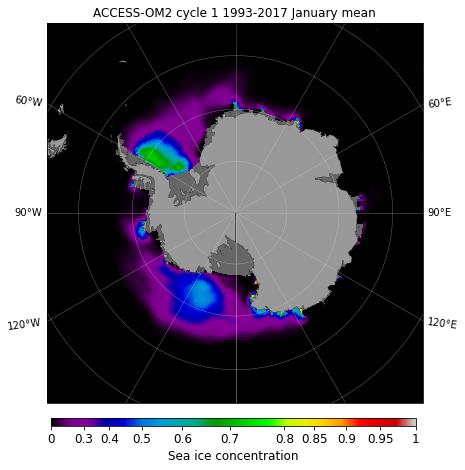

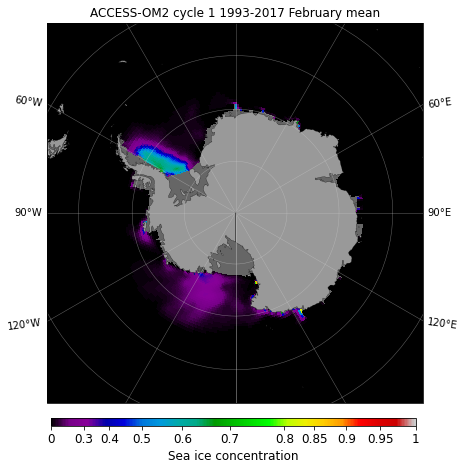

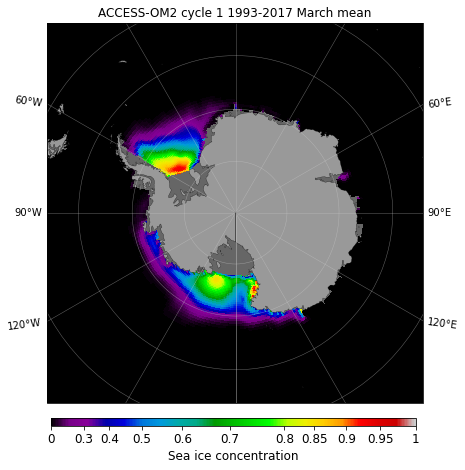

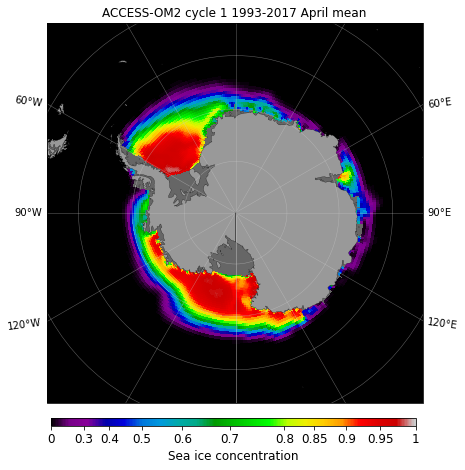

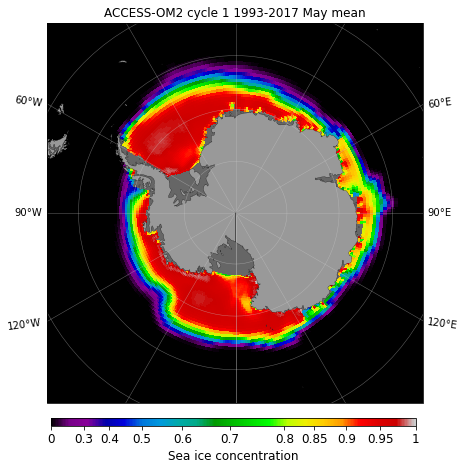

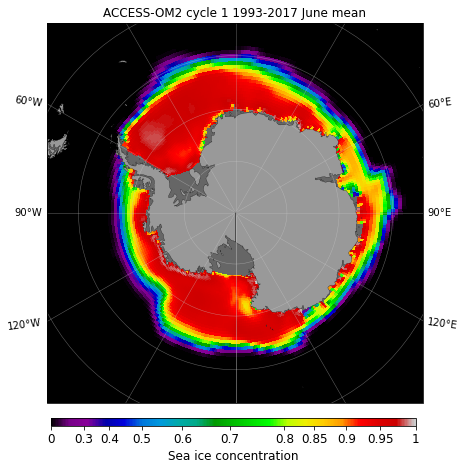

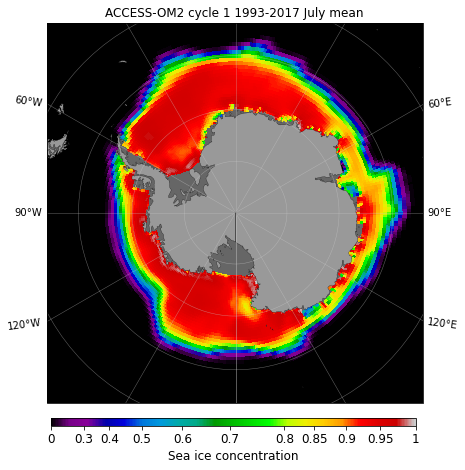

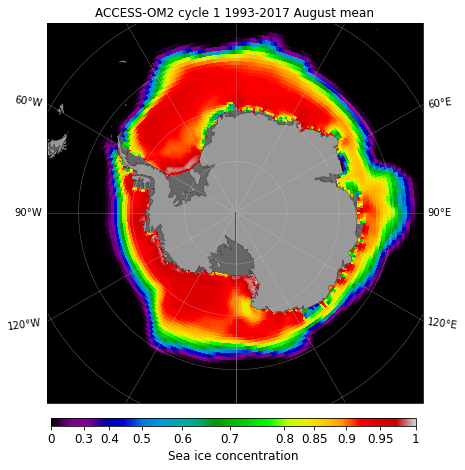

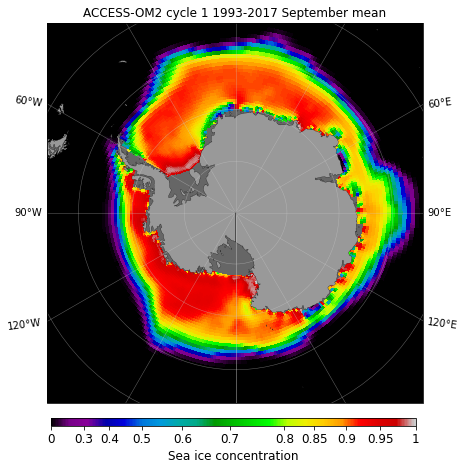

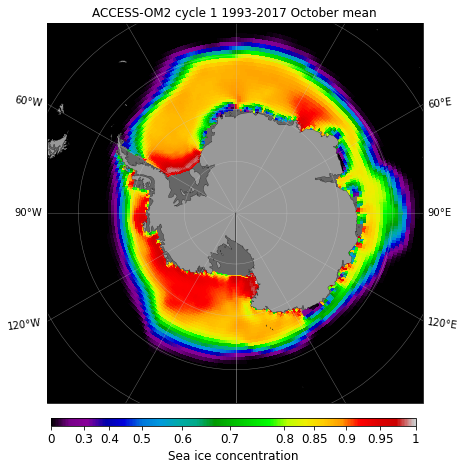

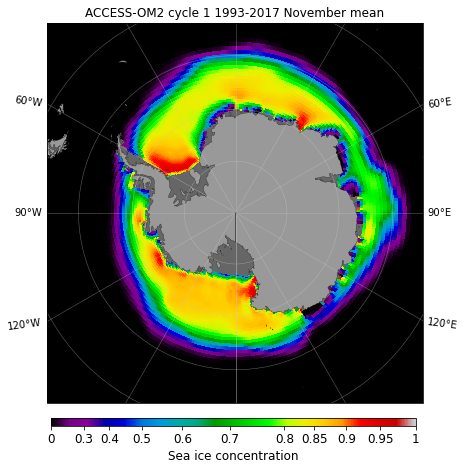

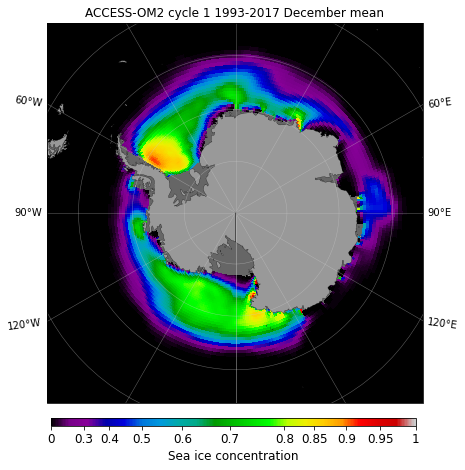

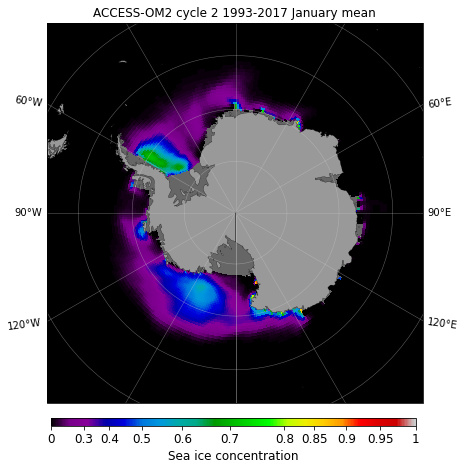

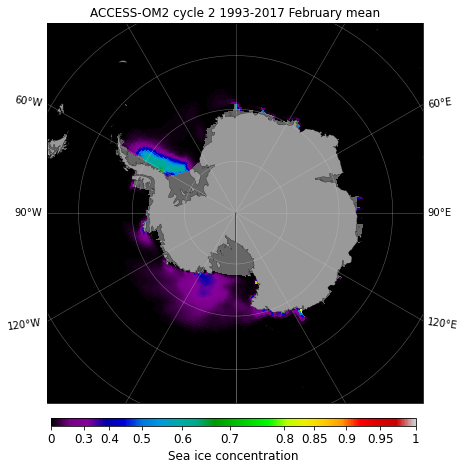

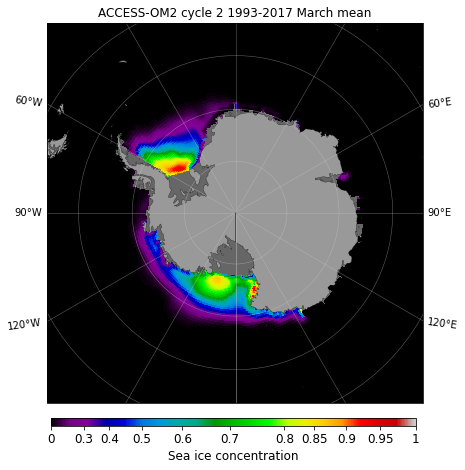

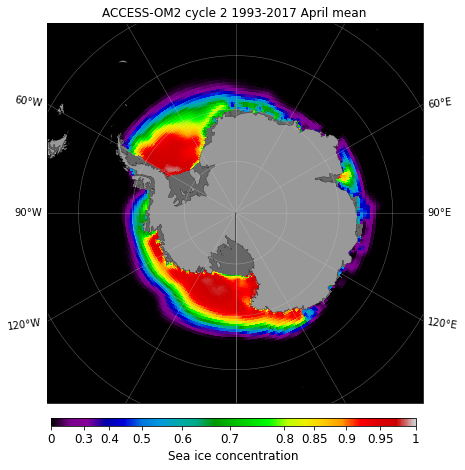

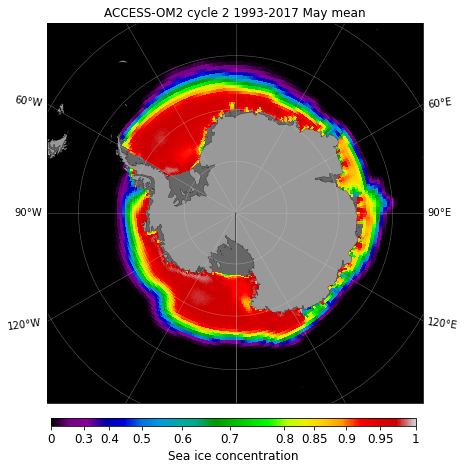

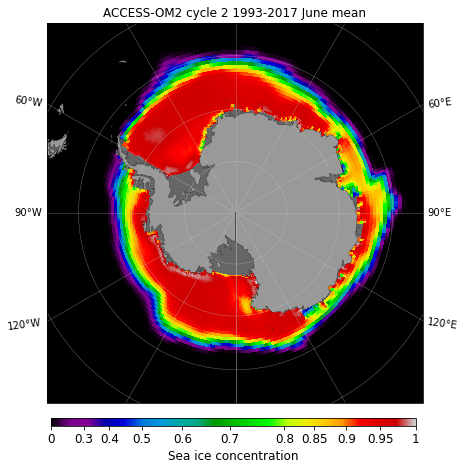

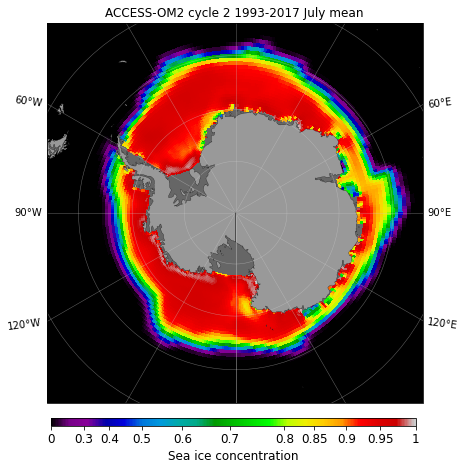

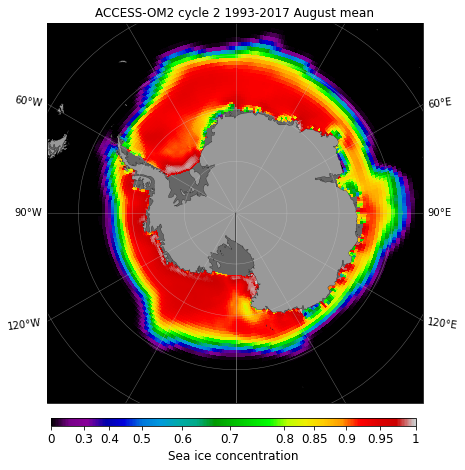

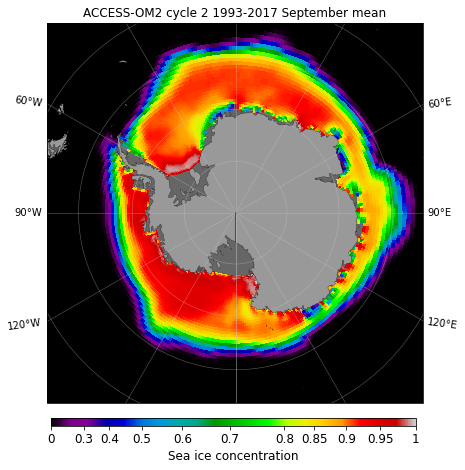

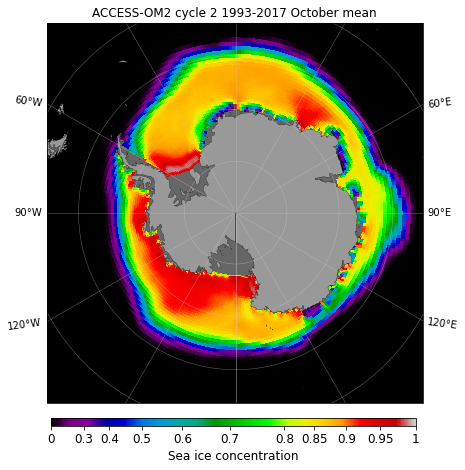

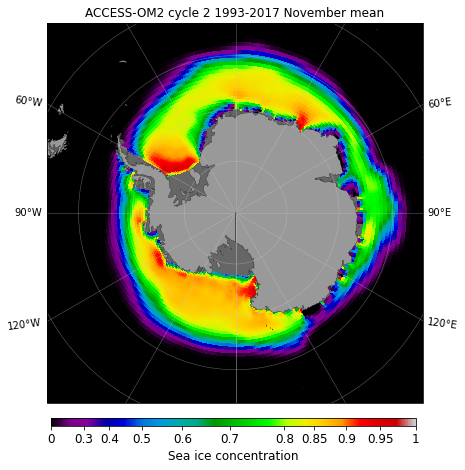

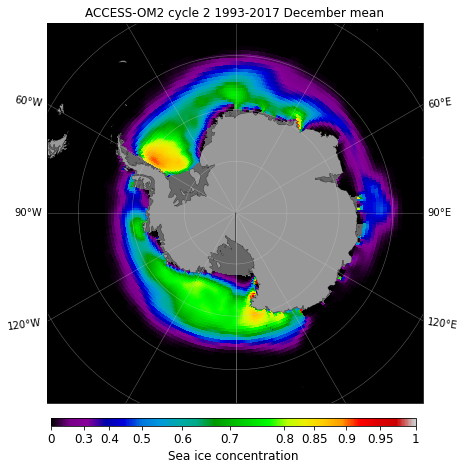

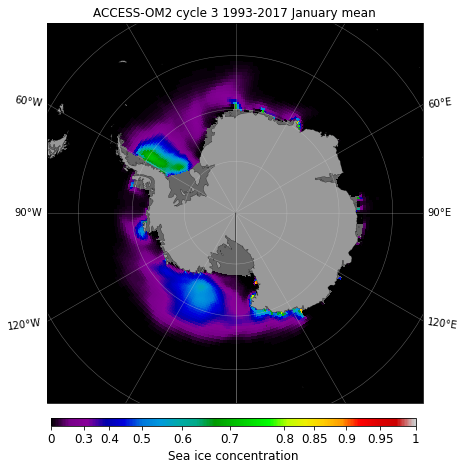

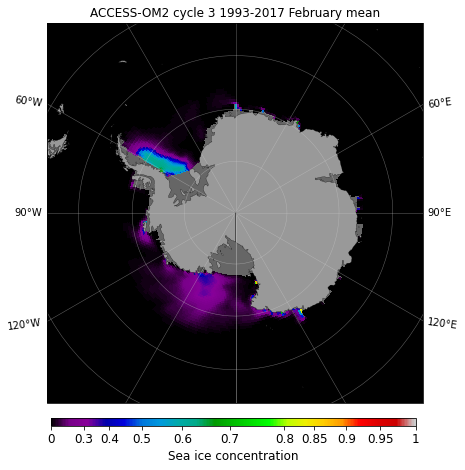

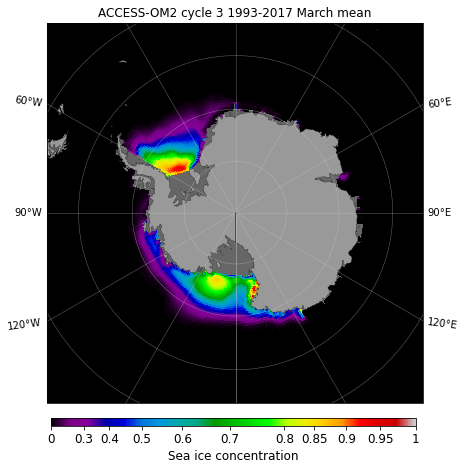

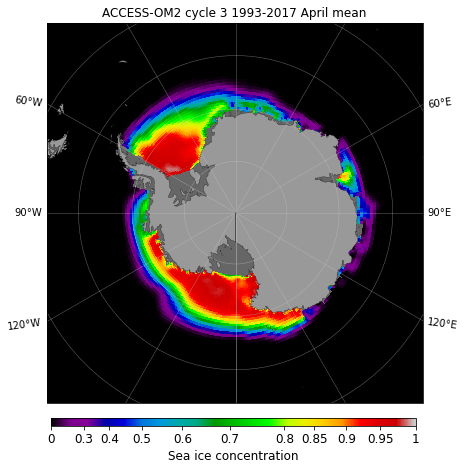

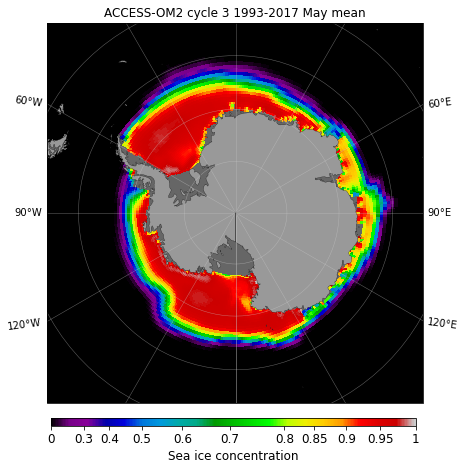

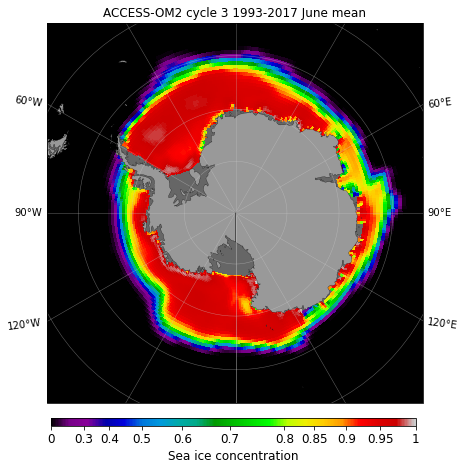

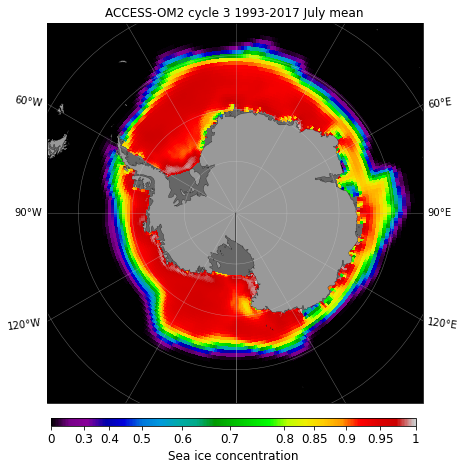

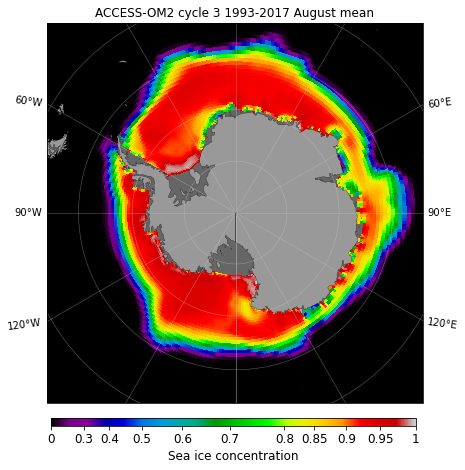

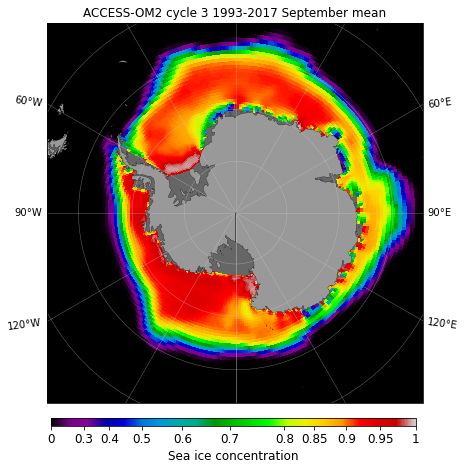

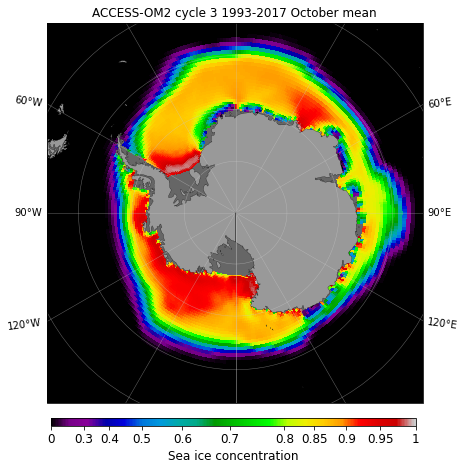

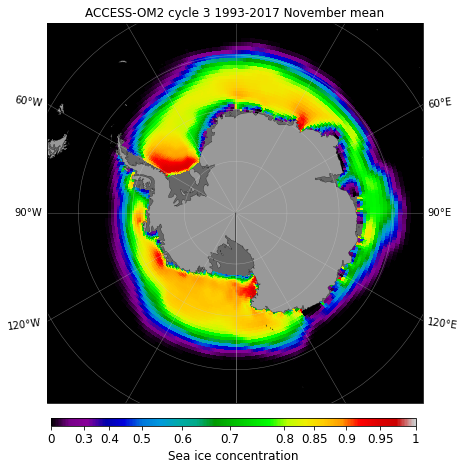

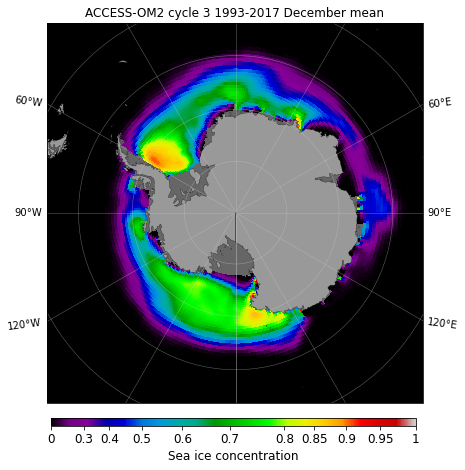

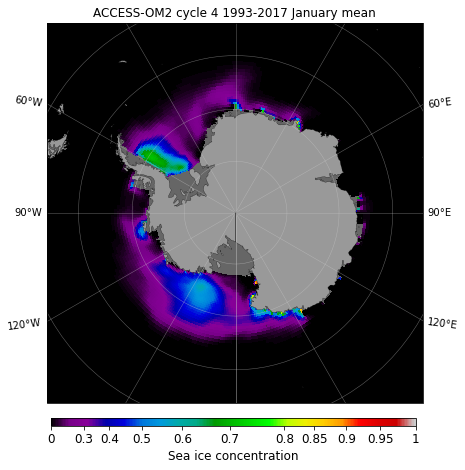

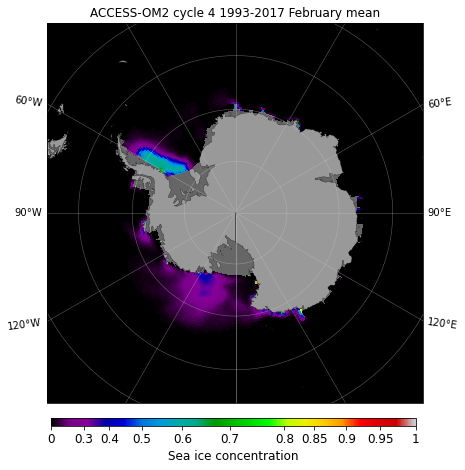

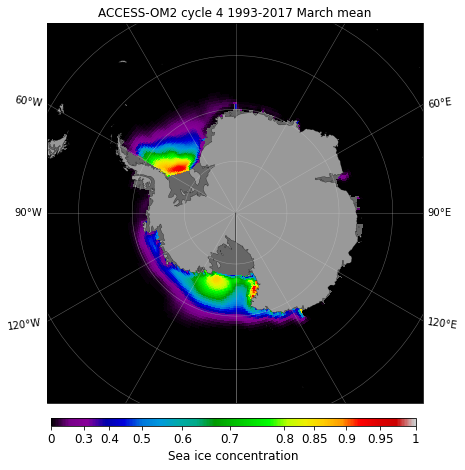

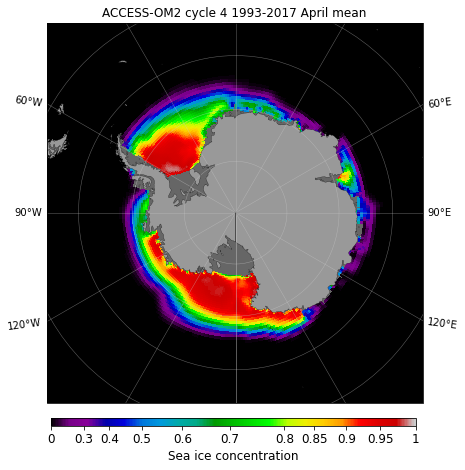

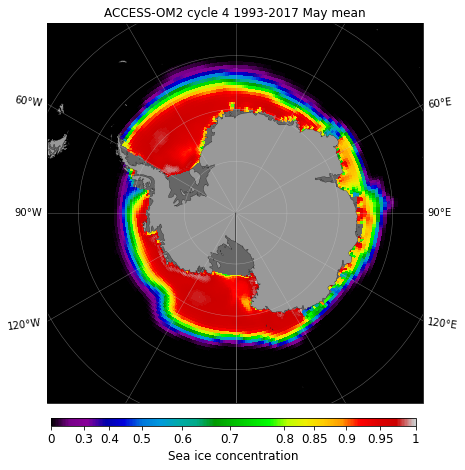

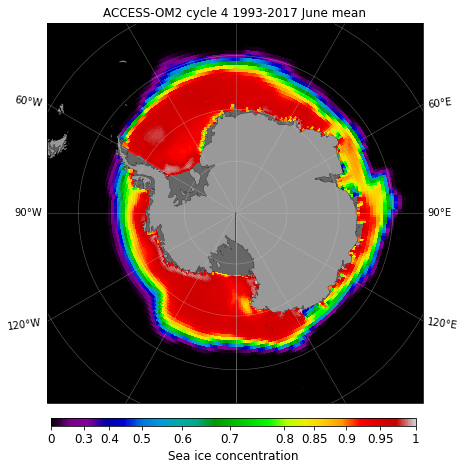

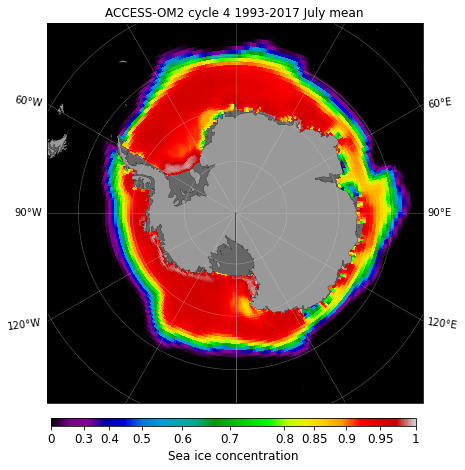

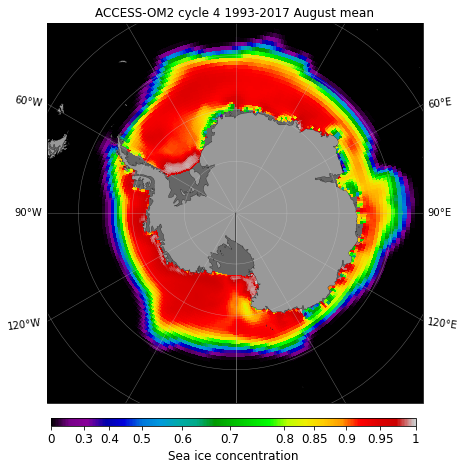

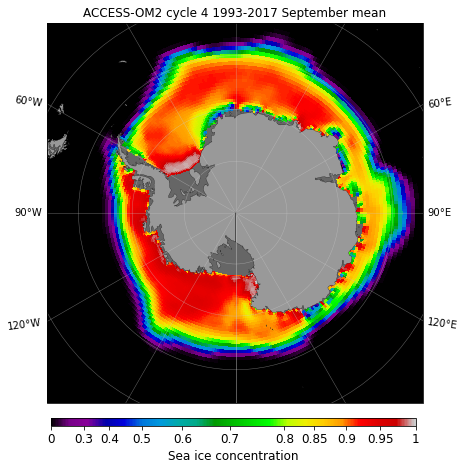

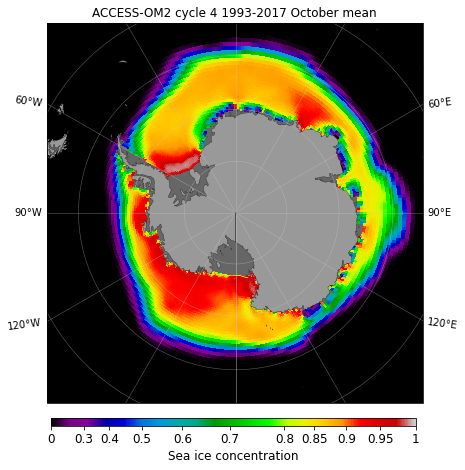

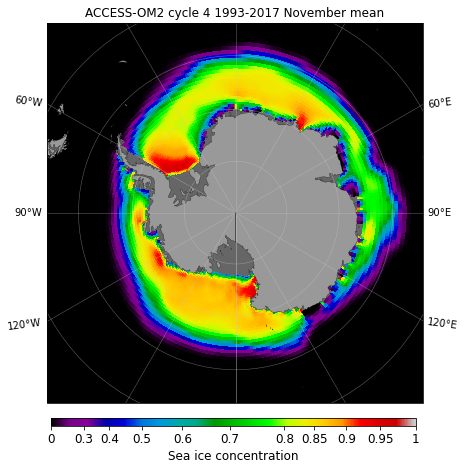

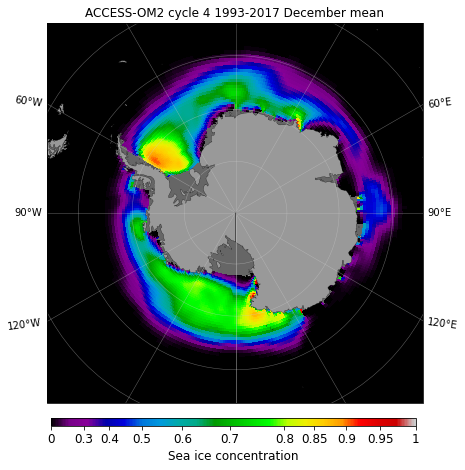

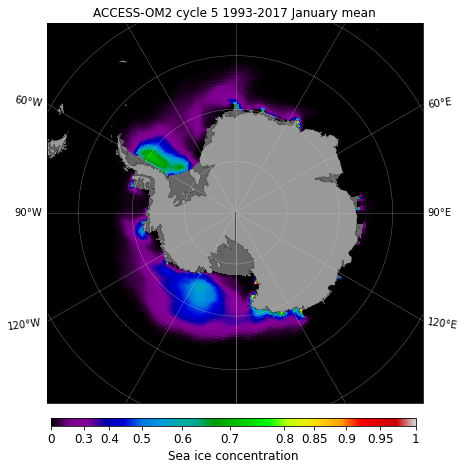

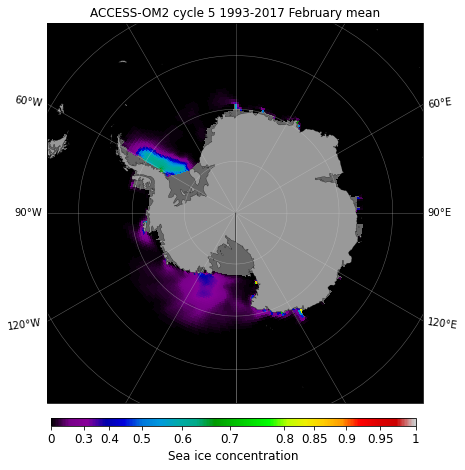

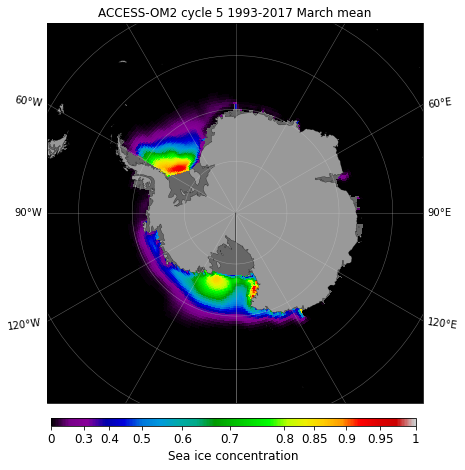

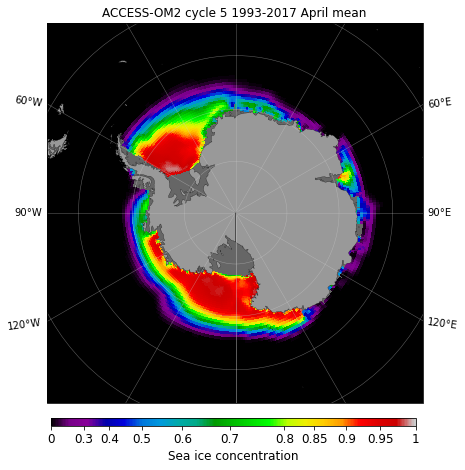

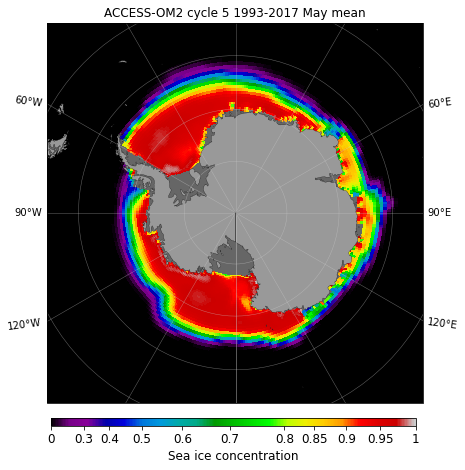

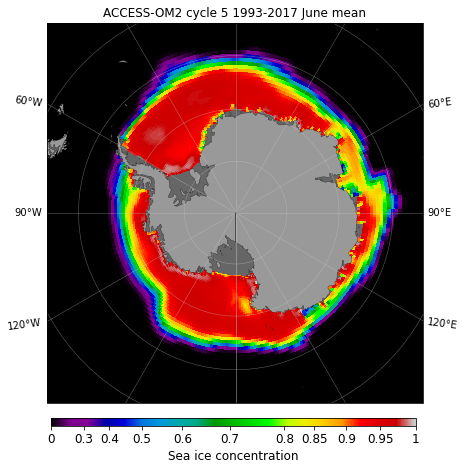

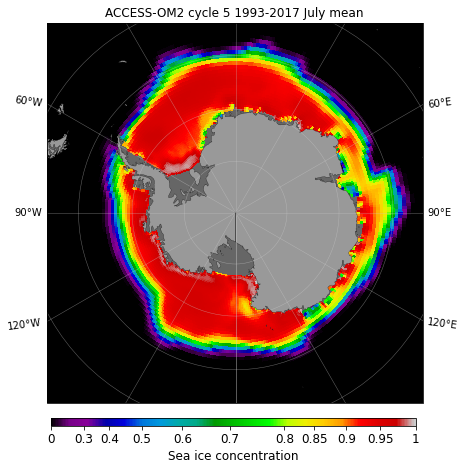

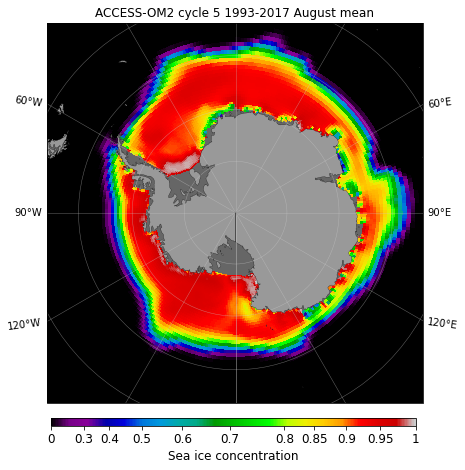

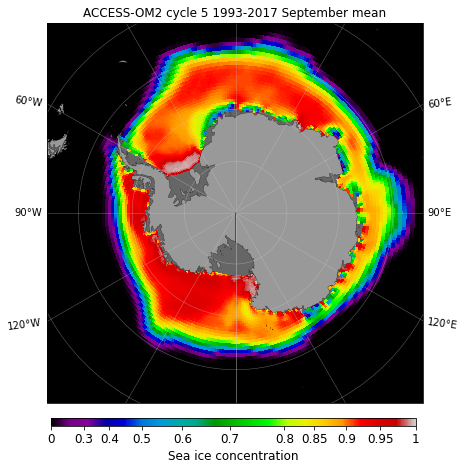

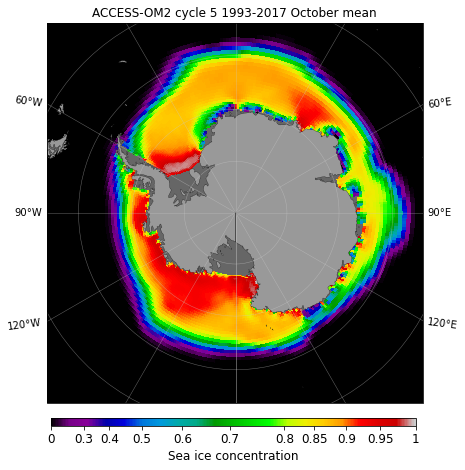

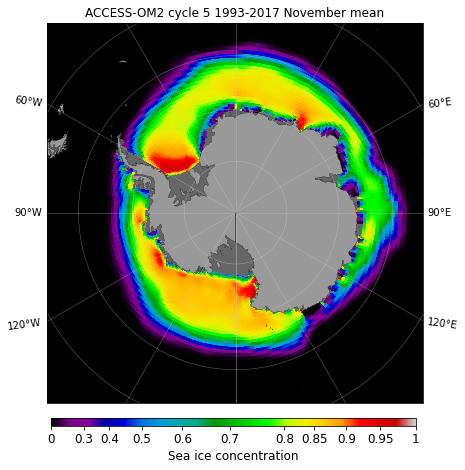

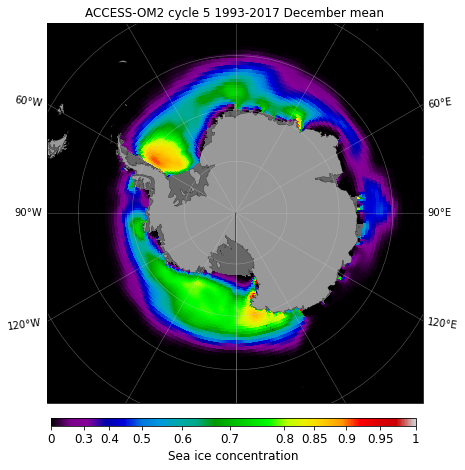

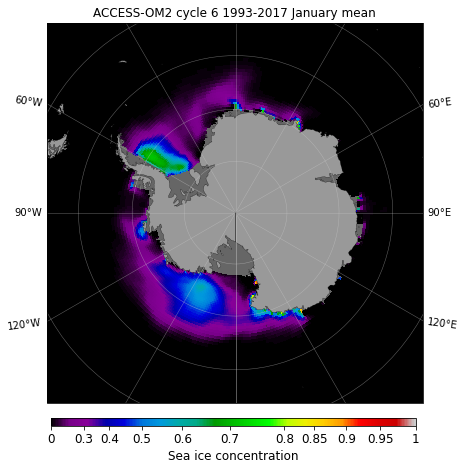

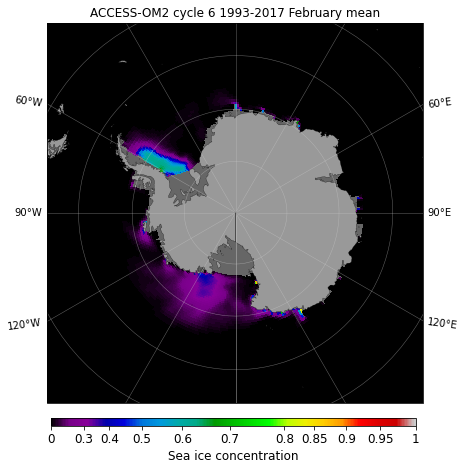

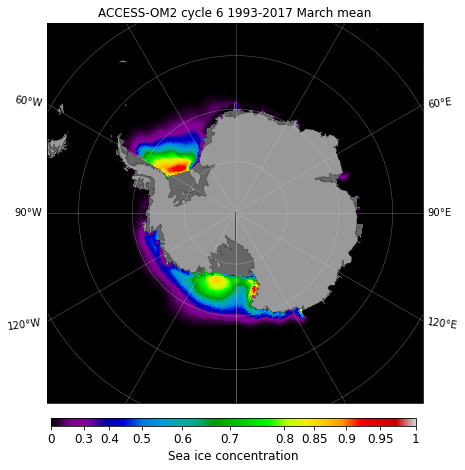

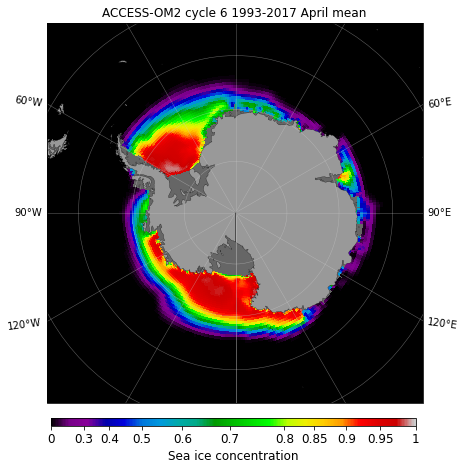

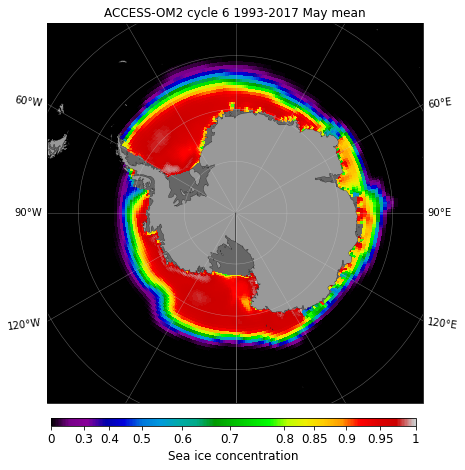

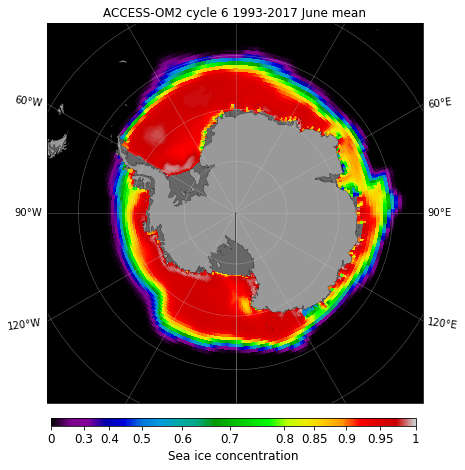

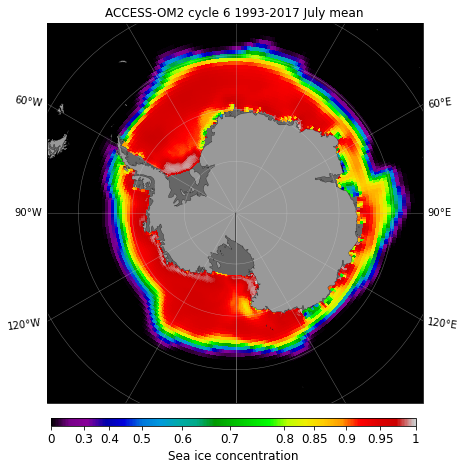

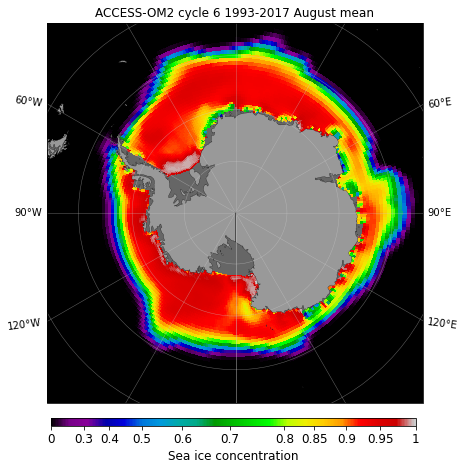

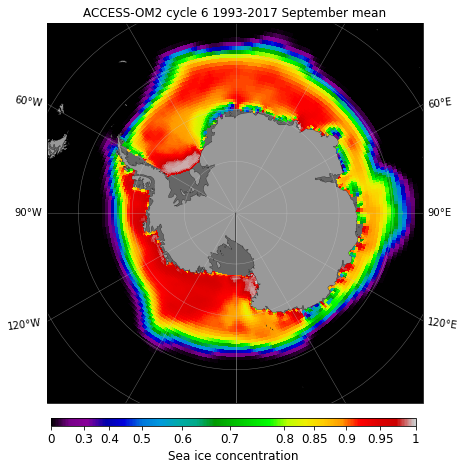

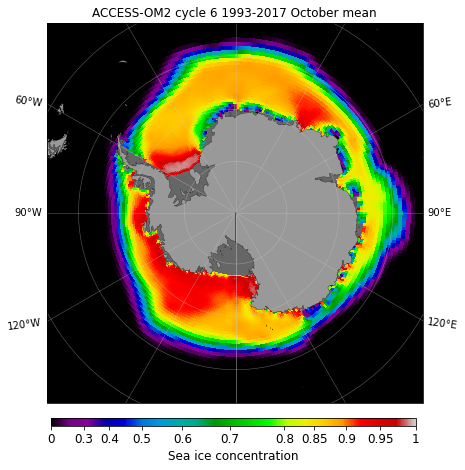

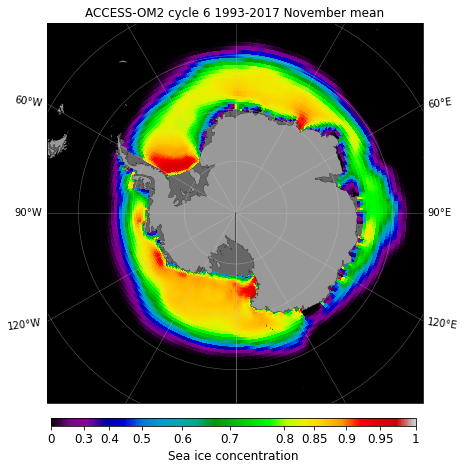

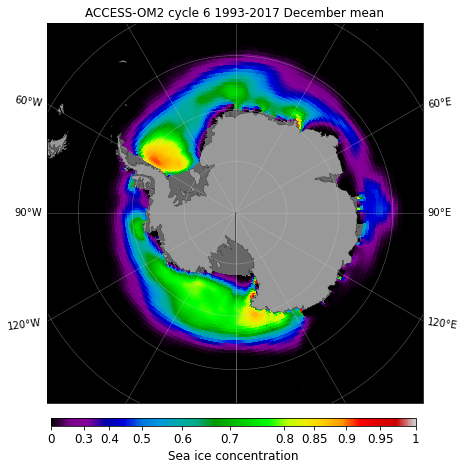

In [28]:
# plot monthly climatologies from each cycle of each model
for hem in ['SH', 'NH']:
    h = eval(hem)
    for ekey in ice_data.keys(): #['1deg']: #['025deg']: #['01deg']: #
        for cycm1, ide in enumerate(ice_data[ekey]):
            for var in ['aice_m_mm']:
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycm1+1), yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([hem, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycm1+1), # FRAGLE! assumes filename cycle number = cycm1+1
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print(' -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)
                        plotSIC(v, **h).set_title(title);
                        savefigure(fname)

In [29]:
# plot monthly climatology difference between cycle n and cycle 1 for each model
for hem in ['SH', 'NH']:
    h = eval(hem)
    for ekey in ice_data.keys(): #['1deg']: #['01deg']: #['025deg']:
        for var in ['aice_m_mm']:
            for m in range(1,13):
                vref = ice_data[ekey][0][var].sel(month=m)
                for cycm2, ide in enumerate(ice_data[ekey][1:]):
                    cycle = cycm2+2

                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
#                     title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean', 'minus cycle 1'])
                    fname = figname('_'.join([hem, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle)+'-cycle1', # FRAGLE! assumes filename cycle number = cycm2+1
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print(' -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m) - vref
                        plotSIC(v, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus cycle 1',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-.15,.1501,.05), cbar_sigfigs=2, **h).set_title(title);
                        savefigure(fname)

 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle2-cycle1_1993-2017_mean_month_01_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle3-cycle1_1993-2017_mean_month_01_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle4-cycle1_1993-2017_mean_month_01_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle5-cycle1_1993-2017_mean_month_01_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle6-cycle1_1993-2017_mean_month_01_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle2-cycle1_1993-2017_mean_month_02_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle3-cycle1_1993-2017_mean_month_02_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle4-cycle1_1993-2017_mean_month_02_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_jra55_iaf_omip2-fixed_cycle5-cycle1_1993-2017_mean_month_02_200dpi.png
 -- skipping figs/SH_aice_m_mm_1deg_j

KeyError: 'aice_m_mm'

In [ ]:
# plot monthly climatologies from obs
for hem in ['SH', 'NH']:
    h = eval(hem)
    for m in range(1,13):
        title = ' '.join(['Passive microwave', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([hem, 'SIC', 'obs', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print(' -- skipping', fname)
        else:
            v = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            plotSIC(v, **h).set_title(title);
            savefigure(fname)

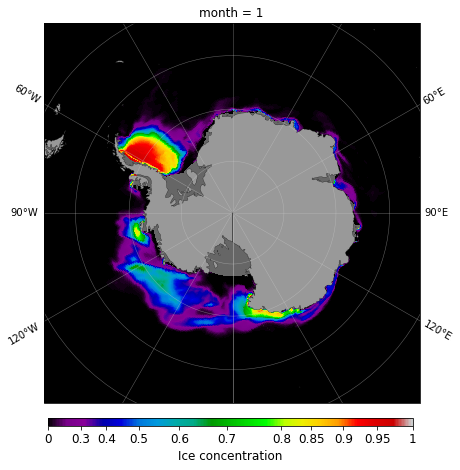

In [53]:
plotSIC(v, **SH);

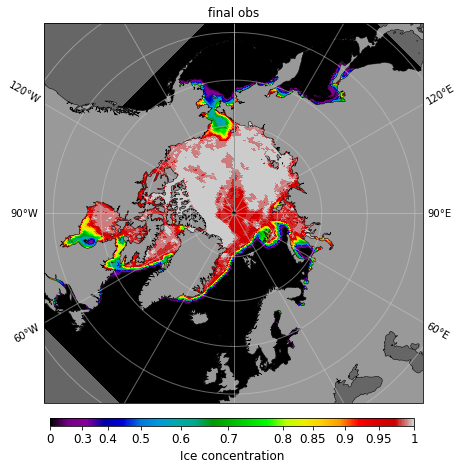

In [22]:
plotSIC(obs_NH.isel(time=-1), **NH).set_title('final obs');

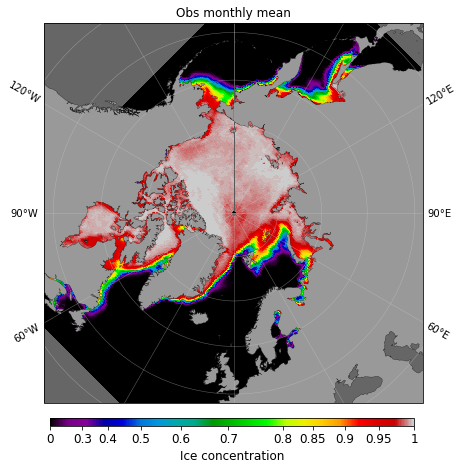

In [25]:
plotSIC(obs_NH_mm.sel(month=1), **NH).set_title('Obs monthly mean');

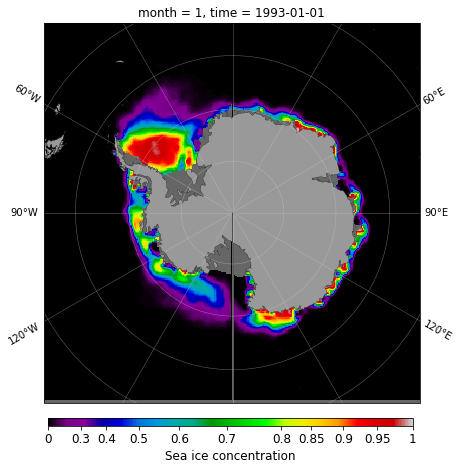

In [27]:
plotSIC(obs_SH_mm.sel(month=1), **SH);